# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split, ParameterSampler, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import stats

# Utilizadas en el punto 2.2 para graficar las distintas configuraciones del modelo
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv", comment="#")

In [3]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

https://www.kaggle.com/ajay1735/hmeq-data

1. El Home Equity dataset (HMEQ), contiene una linea base y la información de rendimiento de los préstamos de 5690 préstamos otorgados recientemente. Esta planilla tiene 1854 registros.

2. El variable objetivo (BAD) es una variable binaria que indica si un solicitante finalmente cumplió o incumplió en la cancelación del préstamo solicitado.  
 * 1 = cliente incumplió con el préstamo 
 * 0 = préstamo cancelado

3. Atributos:
 * LOAN    Amount of the loan request. Monto del préstamo solicitado.
 * MORTDUE Amount due on existing mortgage. Monto adeudado de la hipoteca.
 * VALUE   Value of current property. Valor actual de la propiedad.
 * YOJ     Years at present job. Antiguedad en el trabajo actual.
 * DEROG   Number of major derogatory reports. Número de informes negativos importantes.
 * DELINQ  Number of delinquent credit lines. Cantidad de créditos no pagados.
 * CLAGE   Age of oldest trade line in months. Edad de la línea comercial más antigua en meses.
 * NINQ    Number of recent credit lines. Número de líneas de crédito recientes.
 * CLNO    Number of credit lines. Número de linas de crédito.
 * DEBTINC Debt-to-income ratio. Relación Deuda / Ingresos.

4. Seleccionaría:
 * DEROG   Number of major derogatory reports. Número de informes negativos importantes.
 * DELIQ   Number of delinquent credit lines. Cantidad de créditos no pagados.
 * CLNO    Number of credit lines. Número de linas de crédito.
 * DEBTINC Debt-to-income ratio. Relación Deuda / Ingresos.




In [4]:
dataset.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


In [5]:
dataset[dataset["DEROG"] == 10]

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1710,1,16800,16204.0,27781.0,1.0,10.0,0.0,190.577097,0.0,9.0,27.146886


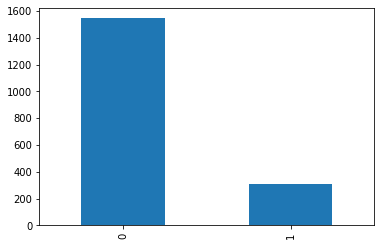

In [6]:
dataset['TARGET'].value_counts().plot.bar();

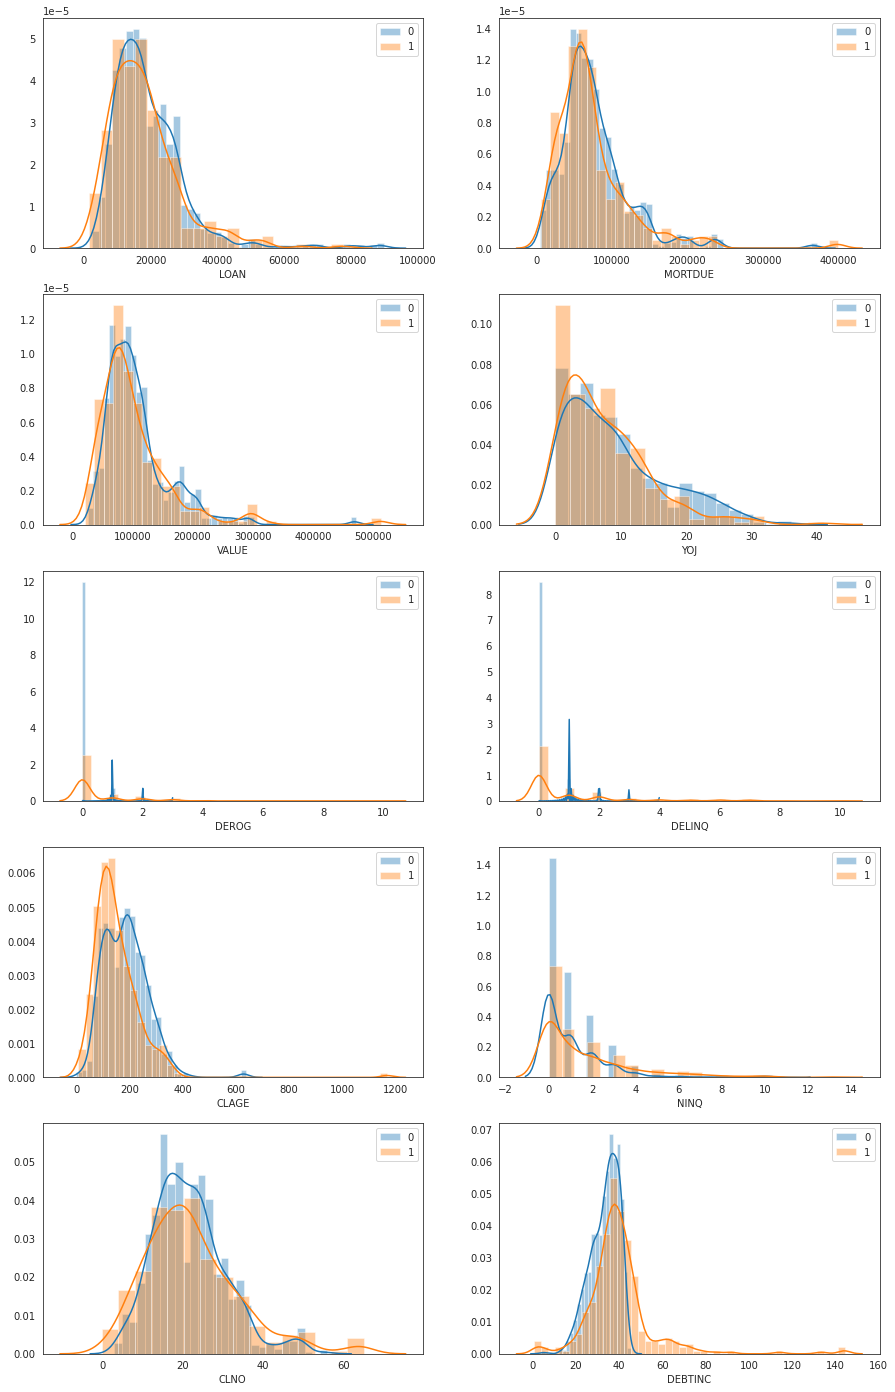

In [7]:
features = dataset.columns[1:]
fig = plt.figure(figsize=(15,5*len(features)))
ds0 = dataset[dataset.TARGET == 0]
ds1 = dataset[dataset.TARGET == 1]
with sns.axes_style("white"):
    for i, col in enumerate(features):
        sp1 = plt.subplot(len(features), 2, i+1)
        sns.distplot(ds0[col], label='0')
        sns.distplot(ds1[col], label='1')
        plt.legend()

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


SGDClassifier es sensitivo a las magnitudes de los valores, por esta razón a continuación se realiza un escalado o normalización.

In [8]:
escalado = StandardScaler()
escalado.fit(X_train)
X_train = escalado.transform(X_train)
X_test  = escalado.transform(X_test) 

### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [9]:
model = SGDClassifier(random_state=0)
classifier=model.fit(X_train, y_train)

In [10]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

**Métricas**

In [11]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1232
           1       0.71      0.42      0.53       251

    accuracy                           0.87      1483
   macro avg       0.80      0.69      0.73      1483
weighted avg       0.86      0.87      0.86      1483



In [12]:
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print('TP: ', tp, '\t FP: ', fp, '\nTN: ', tn, '\t FN: ', fn)

TP:  105 	 FP:  42 
TN:  1190 	 FN:  146


Tomando como True = 1:

$$Accuracy = \frac{TP + TN}{TP + FP + FN + TN} = \frac{105 + 1190}{105 + 42 + 146 + 1190} = 0.87 $$

$$Precision = \frac{TP}{TP + FP} = \frac{105}{105 + 42} = 0.71 $$

$$Recall = \frac{TP}{TP + FN} = \frac{105}{105 + 146} = 0.42 $$

$$F_1 = \frac{2 * Precision * Recall}{Precision + Recall} = \frac{2 * 0.71 * 0.42}{0.71 + 0.42} = 0.53 $$


In [13]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.65      0.34      0.45        58

    accuracy                           0.87       371
   macro avg       0.77      0.65      0.69       371
weighted avg       0.85      0.87      0.85       371



**Matriz de confusión**

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print('TP: ', tp, '\tFP: ', fp, '\nTN: ', tn, '\tFN: ', fn)

TP:  20 	FP:  11 
TN:  302 	FN:  38


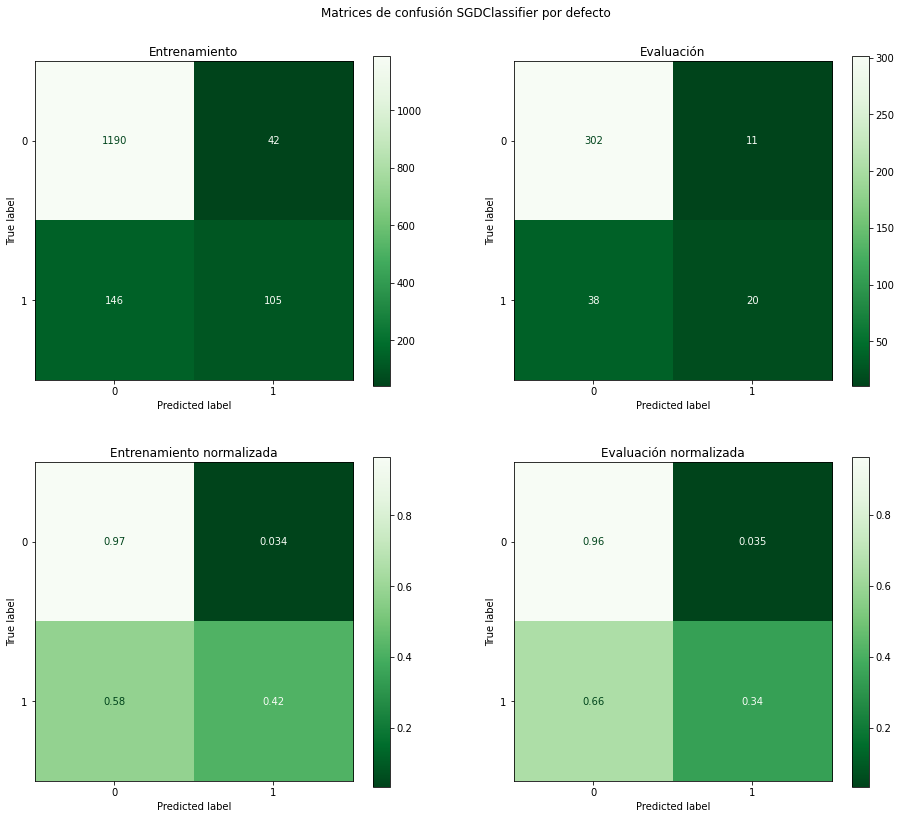

In [15]:
fig, axs = plt.subplots(2,2,figsize=(14,12))
fig.suptitle('Matrices de confusión SGDClassifier por defecto')
axs[0][0].title.set_text('Entrenamiento')
axs[0][1].title.set_text('Evaluación')
fig.tight_layout(pad=5.0)
np.set_printoptions(precision=2)
titles_options = [("Entrenamiento", 0, 0, X_train, y_train, None, 'd'),
                  ("Evaluación", 0, 1, X_test, y_test,  None, 'd'),
                  ("Entrenamiento normalizada", 1, 0, X_train, y_train, 'true', None),
                  ("Evaluación normalizada", 1, 1, X_test, y_test, 'true', None)
                  ]
for title, row, col, x_val, y_val, norm, val_format in titles_options:
    disp = plot_confusion_matrix(classifier, x_val, y_val,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Greens_r,
                                 normalize=norm,
                                 values_format=val_format,
                                 ax=axs[row][col]
                                 )
    disp.ax_.set_title(title)


### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [16]:
param_grid = {
    'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
    ],
    'learning_rate': [
        'constant',
        'optimal',
        'invscaling', 
        'adaptive', 
    ],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0], 
    'eta0': [0.01, 0.1, 1] 
}

In [17]:
# cv=5 by default.. cross validation 
model = SGDClassifier(random_state=0)
cv = GridSearchCV(model, param_grid, scoring='accuracy')
cv.fit(X_train, y_train);

In [18]:
results = cv.cv_results_
df = pd.DataFrame(results)

In [19]:
df.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.005324,0.000379,0.000557,0.000036,0.848457,0.847278,0.850477,0.859741,0.849015,0.850994,0.009413,59.041667
std,0.003631,0.000353,0.000080,0.000037,0.034169,0.029572,0.016727,0.028054,0.013189,0.021719,0.010763,34.392298
min,0.001861,0.000018,0.000439,0.000004,0.639731,0.646465,0.797980,0.753378,0.800676,0.755328,0.001259,1.000000
25%,0.002973,0.000137,0.000488,0.000017,0.834175,0.835017,0.837542,0.839527,0.834459,0.835466,0.003778,30.000000
50%,0.004047,0.000278,0.000540,0.000024,0.855219,0.858586,0.855219,0.861486,0.854730,0.855023,0.007829,60.000000
75%,0.005391,0.000499,0.000637,0.000039,0.868687,0.861953,0.865320,0.881757,0.858108,0.868525,0.011778,90.250000
max,0.014642,0.002081,0.000755,0.000234,0.882155,0.868687,0.872054,0.891892,0.868243,0.871210,0.091666,120.000000


In [20]:
pd.options.display.max_colwidth = 100
df[['params','mean_test_score','std_test_score','rank_test_score']].head(20)

,params,mean_test_score,std_test_score,rank_test_score
0,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge'}",0.869185,0.006520,23
1,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log'}",0.870539,0.011747,2
2,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge'}",0.843573,0.019373,84
3,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log'}",0.852327,0.003892,71
4,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'hinge'}",0.859068,0.005822,52
5,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'log'}",0.861769,0.009272,49
6,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'hinge'}",0.869185,0.006859,23
7,"{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'log'}",0.869190,0.012286,20
8,"{'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'hinge'}",0.846922,0.013697,82
9,"{'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'log'}",0.855037,0.015274,59


In [21]:
df.sort_values(['mean_test_score','std_test_score','rank_test_score'],
               ascending = [False,True,True],
               inplace=True)
df.reset_index(drop=True,inplace=True)

In [22]:
fig = go.Figure()

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.index, y=df['mean_test_score'], 
                         name='Mean score', mode='markers', marker=dict(color='royalblue'),
                         yaxis='y1',
                         text=df['params'].astype('str')
                         )
             )

fig.add_trace(go.Scatter(x=df.index, y=df['std_test_score'], 
                         name='Std score', mode='markers', marker=dict(color='green'),
                         yaxis = 'y2',
                         text=df['params'].astype('str')
                         )
             )

fig.update_layout(
    title=go.layout.Title(
        text="Reporte para {} configuraciones de parámetros".format(len(df)),
        xref="paper",
        x=0
    ),
    xaxis_title="ranking",
    yaxis_title="Mean test score",
    yaxis2_title="Std test score", 
 )


**Seleccionamos la mejor configuración de hyper parámetros.**

In [23]:
best_model = df.loc[df['rank_test_score'].idxmin()]['params']
best_model

{'alpha': 0.01, 'eta0': 1, 'learning_rate': 'adaptive', 'loss': 'hinge'}

In [24]:
model = SGDClassifier(**best_model, random_state=0)
classifier = model.fit(X_train, y_train)

In [25]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

**Métricas con train**

In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1232
           1       0.92      0.27      0.42       251

    accuracy                           0.87      1483
   macro avg       0.90      0.64      0.68      1483
weighted avg       0.88      0.87      0.84      1483



**Matriz de confusión**

In [27]:
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print('TP: ', tp, '\t FP: ', fp, '\nTN: ', tn, '\t FN: ', fn)

TP:  69 	 FP:  6 
TN:  1226 	 FN:  182


**Métricas con test**

In [28]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       313
           1       0.94      0.28      0.43        58

    accuracy                           0.88       371
   macro avg       0.91      0.64      0.68       371
weighted avg       0.89      0.88      0.86       371



**Matriz de confusión**

In [29]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print('TP: ', tp, '\t FP: ', fp, '\nTN: ', tn, '\t FN: ', fn)

TP:  16 	 FP:  1 
TN:  312 	 FN:  42


**Gráficos**

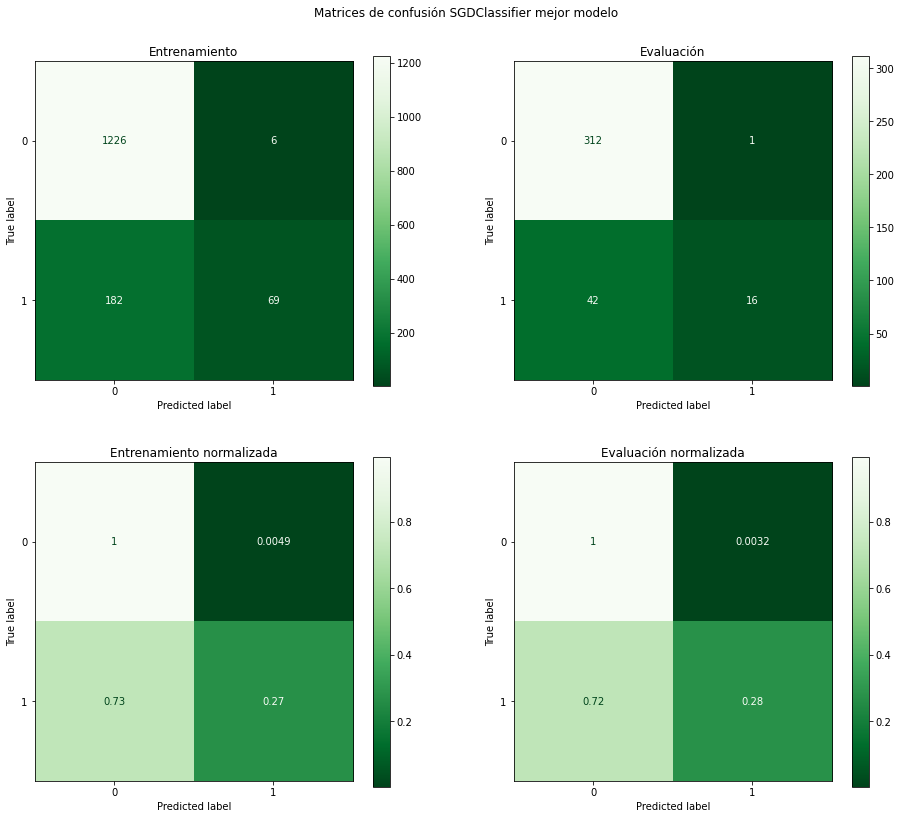

In [30]:
fig, axs = plt.subplots(2,2,figsize=(14,12))
fig.suptitle('Matrices de confusión SGDClassifier mejor modelo')
axs[0][0].title.set_text('Entrenamiento')
axs[0][1].title.set_text('Evaluación')
fig.tight_layout(pad=5.0)
np.set_printoptions(precision=2)
titles_options = [("Entrenamiento", 0, 0, X_train, y_train, None, 'd'),
                  ("Evaluación", 0, 1, X_test, y_test,  None, 'd'),
                  ("Entrenamiento normalizada", 1, 0, X_train, y_train, 'true', None),
                  ("Evaluación normalizada", 1, 1, X_test, y_test, 'true', None)
                  ]
for title, row, col, x_val, y_val, norm, val_format in titles_options:
    disp = plot_confusion_matrix(classifier, x_val, y_val,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Greens_r,
                                 normalize=norm,
                                 values_format=val_format,
                                 ax=axs[row][col]
                                 )
    disp.ax_.set_title(title)

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [31]:
model = DecisionTreeClassifier(random_state=0)
classifier=model.fit(X_train, y_train)

In [32]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [33]:
print('Profundidad máxima del árbol:', model.get_depth())
print('Cantidad máxima de hojas:', model.get_n_leaves())

Profundidad máxima del árbol: 22
Cantidad máxima de hojas: 141


**Métricas con train**

In [34]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483



**Matriz de confusión**

In [35]:
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print('TP: ', tp, '\t FP: ', fp, '\nTN: ', tn, '\t FN: ', fn)

TP:  251 	 FP:  0 
TN:  1232 	 FN:  0


**Métricas con train**

In [36]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



**Matriz de confusión**

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print('TP: ', tp, '\t FP: ', fp, '\nTN: ', tn, '\t FN: ', fn)

TP:  37 	 FP:  23 
TN:  290 	 FN:  21


**Gráficos**

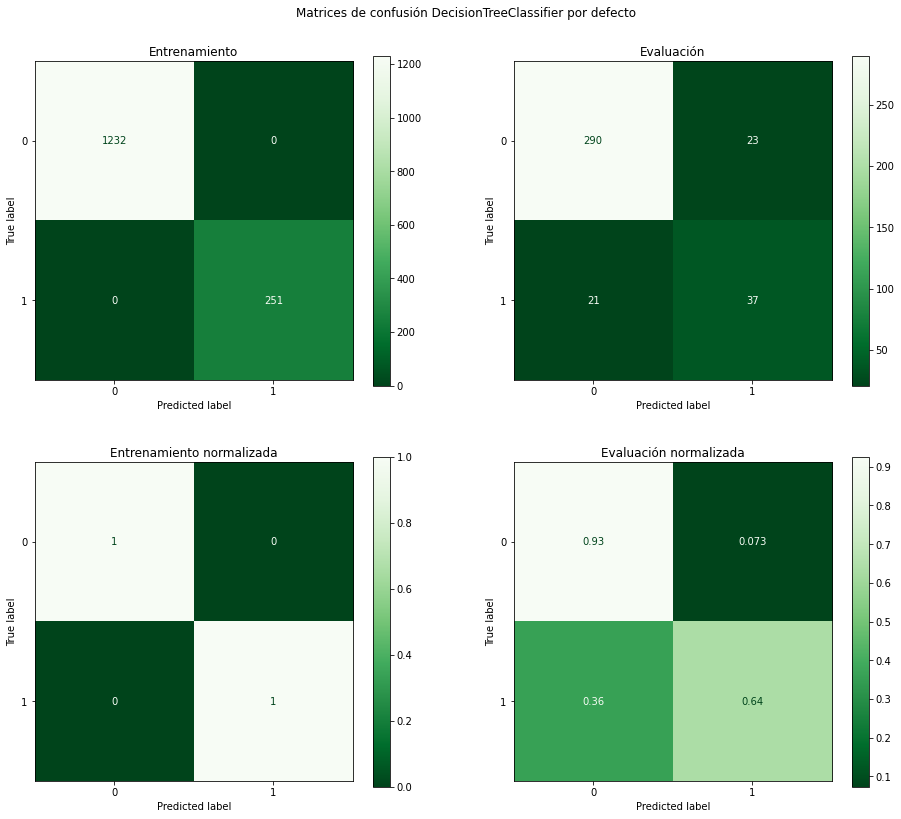

In [38]:
fig, axs = plt.subplots(2,2,figsize=(14,12))
fig.suptitle('Matrices de confusión DecisionTreeClassifier por defecto')
axs[0][0].title.set_text('Entrenamiento')
axs[0][1].title.set_text('Evaluación')
fig.tight_layout(pad=5.0)
np.set_printoptions(precision=2)
titles_options = [("Entrenamiento", 0, 0, X_train, y_train, None, 'd'),
                  ("Evaluación", 0, 1, X_test, y_test,  None, 'd'),
                  ("Entrenamiento normalizada", 1, 0, X_train, y_train, 'true', None),
                  ("Evaluación normalizada", 1, 1, X_test, y_test, 'true', None)
                  ]
for title, row, col, x_val, y_val, norm, val_format in titles_options:
    disp = plot_confusion_matrix(classifier, x_val, y_val,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Greens_r,
                                 normalize=norm,
                                 values_format=val_format,
                                 ax=axs[row][col]
                                 )
    disp.ax_.set_title(title)

Graficamos el árbol de decisión.

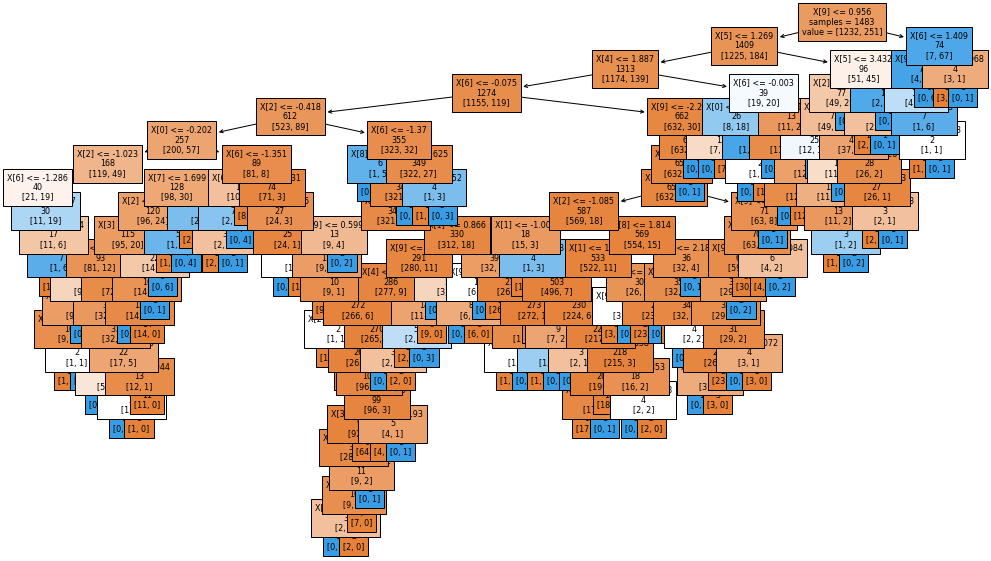

In [39]:
plt.figure(figsize=(17,10))
plot_tree(model, impurity=False, fontsize=8, filled=True, label='root')  #filled=True,
plt.show()

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [40]:
param_grid = {
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(4,20,2),
    'min_samples_leaf': np.arange(1,10),
}


In [41]:
cv = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, scoring='accuracy')
cv.fit(X_train, y_train);

In [42]:
results = cv.cv_results_
df = pd.DataFrame(results)

In [43]:
df.sort_values(['mean_test_score','std_test_score','rank_test_score'],
               ascending = [False,True,True],
               inplace=True)
df.reset_index(drop=True,inplace=True)

In [44]:
fig = go.Figure()

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.index, y=df['mean_test_score'], 
                         name='Mean score', mode='markers', marker=dict(color='royalblue'),
                         yaxis='y1',
                         text=df['params'].astype('str')
                         )
             )

fig.add_trace(go.Scatter(x=df.index, y=df['std_test_score'], 
                         name='Std score', mode='markers', marker=dict(color='green'),
                         yaxis = 'y2',
                         text=df['params'].astype('str')
                         )
             )

fig.update_layout(
    title=go.layout.Title(
        text="Reporte para {} configuraciones de parámetros".format(len(df)),
        xref="paper",
        x=0
    ),
    xaxis_title="ranking",
    yaxis_title="Mean test score",
    yaxis2_title="Std test score", 
)

Seleccionamos la mejor configuración de hiperparámetros.

In [45]:
best_model = df.loc[df['rank_test_score'].idxmin()]['params']
best_model

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'splitter': 'best'}

In [46]:
model = DecisionTreeClassifier(**best_model, random_state=0)
classifier=model.fit(X_train, y_train)

In [47]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [48]:
print('Profundidad máxima del árbol:', model.get_depth())
print('Cantidad máxima de hojas:', model.get_n_leaves())

Profundidad máxima del árbol: 10
Cantidad máxima de hojas: 67


**Métricas con train**

In [49]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1232
           1       0.99      0.71      0.83       251

    accuracy                           0.95      1483
   macro avg       0.97      0.86      0.90      1483
weighted avg       0.95      0.95      0.95      1483



**Matriz de confusión**

In [50]:
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print('TP: ', tp, '\t FP: ', fp, '\nTN: ', tn, '\t FN: ', fn)

TP:  179 	 FP:  2 
TN:  1230 	 FN:  72


**Métricas con test**

In [51]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       313
           1       0.75      0.52      0.61        58

    accuracy                           0.90       371
   macro avg       0.83      0.74      0.78       371
weighted avg       0.89      0.90      0.89       371



**Matriz de confusión**

In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print('TP: ', tp, '\t FP: ', fp, '\nTN: ', tn, '\t FN: ', fn)

TP:  30 	 FP:  10 
TN:  303 	 FN:  28


**Gráfico** 

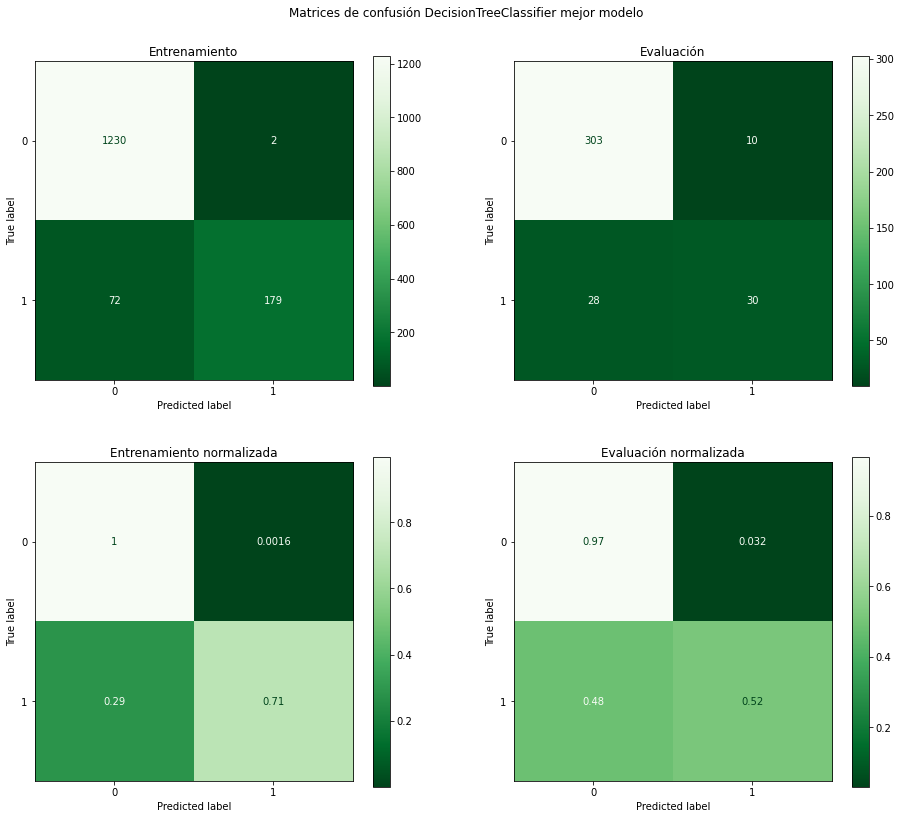

In [53]:
fig, axs = plt.subplots(2,2,figsize=(14,12))
fig.suptitle('Matrices de confusión DecisionTreeClassifier mejor modelo')
axs[0][0].title.set_text('Entrenamiento')
axs[0][1].title.set_text('Evaluación')
fig.tight_layout(pad=5.0)
np.set_printoptions(precision=2)
titles_options = [("Entrenamiento", 0, 0, X_train, y_train, None, 'd'),
                  ("Evaluación", 0, 1, X_test, y_test,  None, 'd'),
                  ("Entrenamiento normalizada", 1, 0, X_train, y_train, 'true', None),
                  ("Evaluación normalizada", 1, 1, X_test, y_test, 'true', None)
                  ]
for title, row, col, x_val, y_val, norm, val_format in titles_options:
    disp = plot_confusion_matrix(classifier, x_val, y_val,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Greens_r,
                                 normalize=norm,
                                 values_format=val_format,
                                 ax=axs[row][col]
                                 )
    disp.ax_.set_title(title)

Graficamos el árbol de decisión.

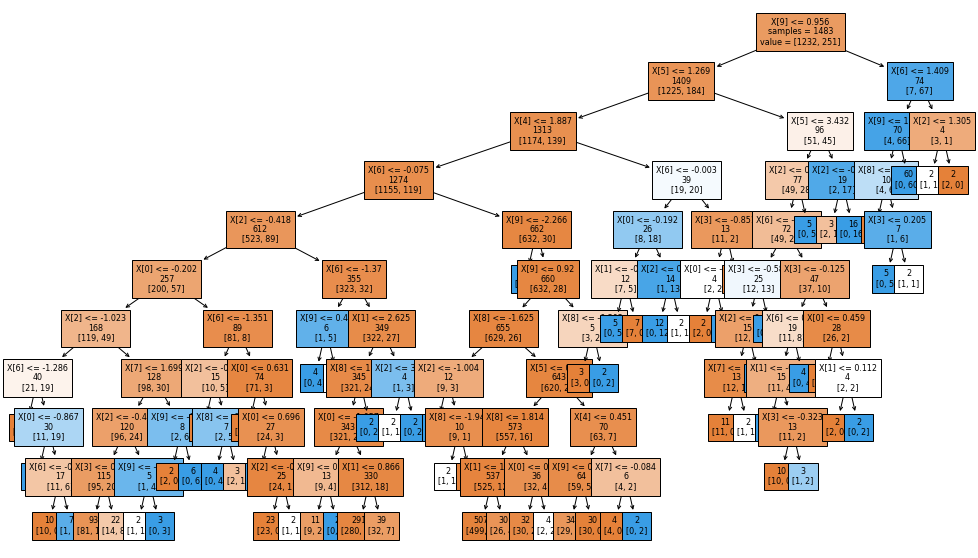

In [54]:
plt.figure(figsize=(17,10))
plot_tree(model, impurity=False, fontsize=8, filled=True, label='root')  #filled=True,
plt.show()

## Conclusión

Después de haber ejecutado algunos modelos con diferentes tipos de parámetros, observamos que con el modelo del árbol de decisión con hiperparámetros se obtienen mejores métricas (precisión, recall, f1-score) que con el modelo de descenso de gradiente estocástico.

También evidenciamos que el dataset tiene clases desbalanceadas, ya que de un total de 1854 préstamos, sólo un 25% corresponde a préstamos no cancelados. 
